# Random Forest Regressor

### Theory

We construct a _RandomForestRegressor_ in exactly the same way as a _RandomForestClassifier_, except that we use regression trees rather than their classification counterparts. As a result, our predicted value $\hat{y}$ for a given data sample $X$ is not the majority vote of class label predictions made by the trees. Instead, it is taken as mean of all predicted values by our regression trees in the ensemble. Suppose that we construct a random forest with $M$ number of trees, the prediction $\hat{y}_j$ from the sample $X_j$ is calculated as,

$$\hat{y}_j = \frac{1}{M}\sum_{m=1}^{T} \hat{y}_{jm}$$

where $\hat{y}_{jm}$ denotes the prediction associated with $X_j$ from the $t$-th tree in the forest. We can quantify the uncertainty of the prediction $\hat{y}_j$ via the standard deviation $\sigma_j$ calculated through the variance, 

$$\sigma_j^2 = \frac{1}{M}\sum_{m=1}^{M} (\hat{y}_{jm} - \hat{y}_j)^2$$

Our implementation generates and stores a prediction matrix $\mathbf{\hat{Y}}$ for $X$ when the _predict()_ method is called. $\mathbf{\hat{Y}}$ has the shape $N \times T$ where $N$ is the number of samples in $X$ such that each element is given as $\hat{Y}_{jm}$. Using _axis=1_, we can compute the mean prediction $\hat{y}_j$ and its variance $\sigma_j^2$ across all trees. Likewise, computation of the feature importances is also performed in the same manner. Let us denote the feature importance for a given feature $j$ from the tree labelled $m$ as $\mathcal{I}_{jm}$. We then define the feature importance matrix $\tilde{\mathcal{I}}$ as such,

$$
\tilde{\mathcal{I}} =
\begin{bmatrix}
\mathcal{I}_{11} & \mathcal{I}_{12} & \mathcal{I}_{13} & \cdots & \mathcal{I}_{1K} \\
\mathcal{I}_{21} & \mathcal{I}_{22} & \mathcal{I}_{23} & \cdots & \mathcal{I}_{2K} \\
\mathcal{I}_{13} & \mathcal{I}_{23} & \mathcal{I}_{33} & \cdots & \mathcal{I}_{3K} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\mathcal{I}_{1M} & \mathcal{I}_{2M} & \mathcal{I}_{3M} & \cdots & \mathcal{I}_{KM}
\end{bmatrix}
$$

The dimensions of $\mathbf{\mathcal{I}}$ are $ M \times K$ where $K$ is the total number of features in $X$. Each row of the matrix yields is the feature vector of a given tree $m$. The feature importance vector of the forest $\tilde{\mathcal{I}}$ is taken by the average along the zero-th axis (_axis=0_), 

$$\mathcal{I}_j = \frac{1}{M} \sum_{m=1}^{M} \mathcal{I}_{jm} $$

In which, $\tilde{\mathcal{I}}_j$ is the forest-level importance of the $j$-th feature. Additionally, we also compute the variance, 

$$\text{Var}[\mathcal{I}_j] = \frac{1}{M}\sum_{m=1}^{M} (\mathcal{I}_{jm} - \text{E}[\mathcal{I}_{j}])^2$$

Note that expected value $\text{E}[\mathcal{I}_{j}]$ is the mean. By default we normalise the feature importance vector such that its elements their variance are given by, 

$$
\hat{\mathcal{I}}_j = \frac{\mathcal{I}_j}{\sum_{k=1}^{K} \mathcal{I}_k} 
\qquad\qquad
\mathrm{Var}[\hat{\mathcal{I}}_j] = \frac{\mathrm{Var}[\mathcal{I}_j]}{\left(\sum_{k=1}^{K} \mathcal{I}_k\right)^2}
$$

In [70]:
# Imports,
import os
import numpy as np
from joblib import Parallel, delayed
from models.DecisionTreeRegressor import DecisionTreeRegressor

class RandomForestRegressor():
    """Class for the random forest regressor ensemble model.

    PARAMETERS
    n_trees (int): The number of decision trees in the random forest.
    max_depth (int): The maximum number of layers a given tree may have.
    min_depth (int): The minimum number of layers a given tree may have.
    bootstrap_ratio (0 < r < 1): This is the ratio between the number of samples in a given random subset over the full dataset.
    randomise_depth (bool): Toggle whether or not to randomise the max depth of a given tree between min_depth and max_depth."""

    def __init__(self, n_trees, max_depth=None, min_depth=1, min_samples_split=2, min_samples_leaf=1, 
                 bootstrap_ratio=1,  randomise_depth=False, criterion="MSE", feature_subsampling=True, label=False):
        """Constructor method for the random forest ensemble model. Placeholder and class variables are assigned using this method."""

        # Class variables,
        self.n_trees, self.max_depth, self.min_depth, self.criterion = n_trees, max_depth, min_depth, criterion
        self.min_samples_split, self.min_samples_leaf = min_samples_split, min_samples_leaf
        self.bootstrap_ratio, self.randomise_depth = bootstrap_ratio, randomise_depth
        self.label = "random forest" if not label else label
        self.model_score = None
        self.n_features = None
        self.n_samples = None
        self.prediction_matrix = None

        # Feature importance analysis,
        self.feature_importances = None
        self.feature_importances_vars = None
        self.feature_importances_idxs = None
        self.feature_subsampling = feature_subsampling

        # Ensemble list,
        self.trees = []

    def fit(self, X, y, n_jobs=-1):

        # Storing number of samples and features,
        self.n_samples, self.n_features = X.shape[0], X.shape[1]

        # Assigning all cores for fitting (default behaviour),
        if n_jobs == -1:
            n_jobs = os.cpu_count()

        if n_jobs == 1:
            self.trees = [self._fit_tree(X, y, tree_idx) for tree_idx in range(self.n_trees)] # <-- Fitting the trees sequentially.
        else:
            self.trees = Parallel(n_jobs=n_jobs)(delayed(self._fit_tree)(X, y, tree_idx) for tree_idx in range(self.n_trees)) # <-- Fitting the trees in parallel.

    def predict(self, X, vars=False):
        """This function returns the class prediction of a single data sample."""

        # Placeholder,
        n_samples = len(X)
        trees_pred = np.empty(shape=(n_samples, self.n_trees))

        # Looping over all trees,
        for tree_idx, tree in enumerate(self.trees):

            # All tree predictions for a given sample,
            tree_preds = tree.predict(X)
            trees_pred[:, tree_idx] = tree_preds

        # Calculating the average
        self.prediction_matrix = trees_pred
        forest_pred = np.mean(trees_pred, axis=1)

        # Computing variance,
        preds_var = np.var(trees_pred, axis=1) if vars else None

        # Returning model predictions,
        return (forest_pred, preds_var) if vars else forest_pred

    def score(self, X, y):
        """Returns the prediction accuracy of the model on a given dataset."""

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing R2 coefficient as the score,
        SS_res = np.sum((y - y_preds)**2)
        SS_total = np.sum((y - np.mean(y))**2)
        score = 1 - (SS_res/SS_total)

        # Assigning score,
        self.model_score = score

        return score

    def compute_importances(self, norm=True, vars=False):
        """This function returnes the normalised feature importances aggregated over all trees in the forest."""

        # Initialising importances vector,
        cumulative_importances = np.zeros(shape=(self.n_trees, self.n_features))

        # Looping over all trees,
        for tree_idx, tree in enumerate(self.trees):

            # Calculating the tree's importances contributions,
            importances_tree = tree.compute_importances(norm=False)

            # Adding contributions,
            cumulative_importances[tree_idx] += importances_tree

        # Storing all contributions in a matrix,
        self.feature_importances_matrix = cumulative_importances

        # Computing the feature importances (forest-level),
        feature_importances = np.mean(cumulative_importances, axis=0)
        norm_factor = np.sum(feature_importances) # <-- Normalisation factor
        self.feature_importances_vector = feature_importances/norm_factor if norm else feature_importances

        # Computing variance (optional),
        if vars and norm:
            self.feature_importances_vars = np.var(cumulative_importances, axis=0)/norm_factor**2
        elif vars:
            self.feature_importances_vars = np.var(cumulative_importances, axis=0)
        else:
            pass

        # Storing the sorted feature importances indices,
        self.feature_importances_idxs = np.argsort(self.feature_importances_vector)[::-1]

        return (self.feature_importances_vector, self.feature_importances_vars) if vars else self.feature_importances_vector
    
    def _fit_tree(self, X, y, tree_idx):
        """This a helper function that fits a tree of the random forest using boostrapping. It is wrapped by 
        the fit() method which employes threading to populate the random forest."""

        # Selecting a subset of the training data (bootstrapping),
        X_sub, y_sub = self._bootstrap(X, y)

        # Determining the max depth of the tree,
        if self.randomise_depth:
            tree_depth = np.random.randint(self.min_depth, self.max_depth, 1)[0]
        else:
            tree_depth=self.max_depth

        # Creating and fitting tree,
        tree = DecisionTreeRegressor(max_depth=tree_depth, criterion=self.criterion, feature_subsampling=self.feature_subsampling)
        tree.label = f"tree {tree_idx}"
        tree.fit(X_sub, y_sub)

        # We return the fitted tree,
        return tree

    def _bootstrap(self, X, y):
        """Helper function used to created a random subset from a larger set of data points. Returns a tuple."""

        # Determining the number of samples in the full set and subset,
        n_samples = X.shape[0]
        n_subsamples = int(self.bootstrap_ratio*n_samples)

        # Computing the indices of the subset,
        subset_idxs = np.random.choice(n_samples, size=n_subsamples, replace=True)

        # Returning subset,
        return X[subset_idxs], y[subset_idxs]

    def _repr_html_(self):
        """Compact HTML GUI as the object representation in Jupyter Notebook."""
        html = f"""
        <div style="
            border:1px solid black;
            border-radius:6px;
            font-family:Arial, sans-serif;
            font-size:12px;
            line-height:1.2;
            width:fit-content;
            background:white;
            color:black;
            padding-left:8px;
            padding-right:8px;
        ">
            <!-- Title bar -->
            <i>{self.label}</i>
            <div style="
                background:#e0e0e0;
                padding:3px 6px;
                font-weight:bold;
                border-bottom:1px solid black;
                border-top-left-radius:6px;
                border-top-right-radius:6px;
                color:black;
            ">
                RandomForestRegressor
                <div style="margin-top:2px;">
                    <img src="randomforest_icon.png" alt="tree icon" width="40" height="25">
                </div>
            </div>

            <!-- Hyperparameters -->
            <ul style="margin:4px 0 4px 16px; padding:0;">
                <b>Hyperparameters:</b><br>
                n_trees:</b> {self.n_trees}<br>
                max_depth:</b> {self.max_depth}<br>
                min_samples_leaf:</b> {self.min_samples_leaf}<br>
                min_samples_split:</b> {self.min_samples_split}<br>
                bootstrap_ratio: {self.bootstrap_ratio}<br>
                criterion: {self.criterion}
            </ul>

            <!-- Divider -->
            <div style="
                border-top:1px solid #ccc;
                margin:4px 0;
            "></div>

            <!-- Status and other info -->
            <ul style="margin:4px 0 4px 16px; padding:0;">
        """

        if len(self.trees) == 0:
            html += "<b>Status:</b> <span style='color:red;'>Not fitted</span>"
        else:
            html += "<b>Status:</b> <span style='color:green;'>Fitted</span><br>"
            html += f"Score (R^2):</b> {self.model_score:.3f}<br>"
            html += f"n_samples:</b> {self.n_samples}<br>"
            html += f"feature_importances_idxs:</b> {self.feature_importances_idxs}<br>"

        return html

### Basic Example

For a simple test, we use our implementation of the _RandomForestRegressor_ to map the relationship between $X \rightarrow y$ given by $y = e^{-1/4 X} \sin(X)$.

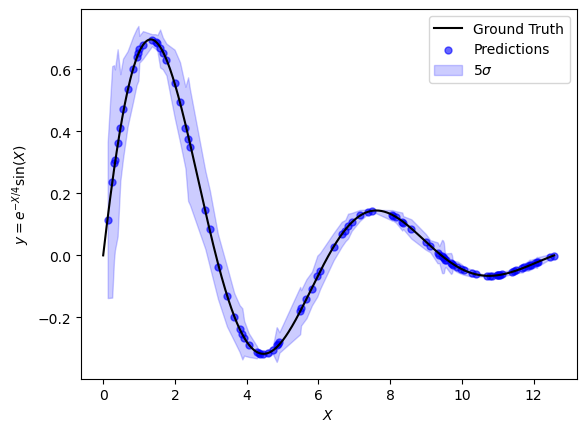

R2 (our model): 0.9997086703369084


In [17]:
# Importing,
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Creating dataset,
X = np.linspace(start=0, stop=4*np.pi, num=500)
y = np.exp(-0.25*X)*np.sin(X)
X = X.reshape(-1, 1) # <-- Transforming into correct shape.

# Creating data split,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Fitting the models,
regressor = RandomForestRegressor(n_trees=25)
regressor.fit(X_train, y_train)

# Computing R2 score,
r2 = regressor.score(X_test, y_test)

# Calculating predictions,
y_pred, y_pred_vars = regressor.predict(X_test, vars=True)

# Sorting,
sort_idx = np.argsort(X_test.ravel())
X_test_sorted = X_test.ravel()[sort_idx]
y_pred_sorted = y_pred[sort_idx]
y_pred_vars_sorted = y_pred_vars[sort_idx]

# Computing standard deviation,
y_pred_confidinv = 5*np.sqrt(y_pred_vars_sorted)

# Plotting,
plt.plot(X, y, color="black", label="Ground Truth")
plt.scatter(X_test_sorted, y_pred_sorted, color="blue", s=25, alpha=0.6, label="Predictions")
plt.fill_between(
    X_test_sorted,
    y_pred_sorted - y_pred_confidinv,
    y_pred_sorted + y_pred_confidinv,
    color="blue",
    alpha=0.2,
    label=r"5$\sigma$"
)
plt.ylabel(r"$y = e^{-X/4}\sin(X)$")
plt.xlabel(r"$X$")
plt.legend()
plt.show()

# Printing,
print(f"R2 (our model): {r2}")

### House Price Prediction Example

Now we consider the _Califorina Housing_ dataset which is very commonly known as a toy dataset for regression models that has real-world applications. By the end of the analysis we want to find out which features are the most importance or influencial in determine the price of a house in California. Using our implementation, 

In [71]:
# Importing,
from sklearn.datasets import fetch_california_housing

# Creating dataset,
housing_dataset = fetch_california_housing(as_frame=False)
X, y = housing_dataset.data[:1000], housing_dataset.target[:1000]

# Creating training split,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

# Creating and fitting model,
regressor = RandomForestRegressor(n_trees=50)
regressor.label = "House Price Predictor"
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.7485662396444892

Comparing this to Sci-kit learn's implemenation,

In [72]:
# Importing,
from sklearn.ensemble import RandomForestRegressor as SKRandomForestRegressor

# Creating and fitting model,
sk_regressor = SKRandomForestRegressor(n_estimators=50)
sk_regressor.fit(X_train, y_train)
sk_regressor.score(X_test, y_test)

0.7394737320269156

Our model appears to often produce a slightly better $R^2$ score with default settings. Let us perform feature importance analysis with our model,

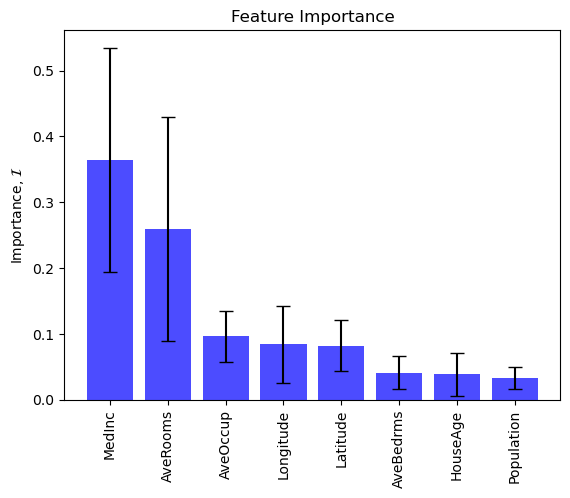

In [76]:
# Computing feature importances,
importances, importances_vars = regressor.compute_importances(vars=True)

# Sorting features by on their importances,
idxs_sorted = np.argsort(importances)[::-1]
importances_sorted = importances[idxs_sorted]
feature_names_sorted = np.asarray(housing_dataset.feature_names)[idxs_sorted]
importances_std_sorted = np.sqrt(importances_vars[idxs_sorted]) # <-- Standard deviation

# Plotting,
fig, ax = plt.subplots()
ax.bar(feature_names_sorted, importances_sorted, yerr=importances_std_sorted, 
       color="blue", alpha=0.7, capsize=5)
ax.set_ylabel(r"Importance, $\mathcal{I}$")
ax.set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

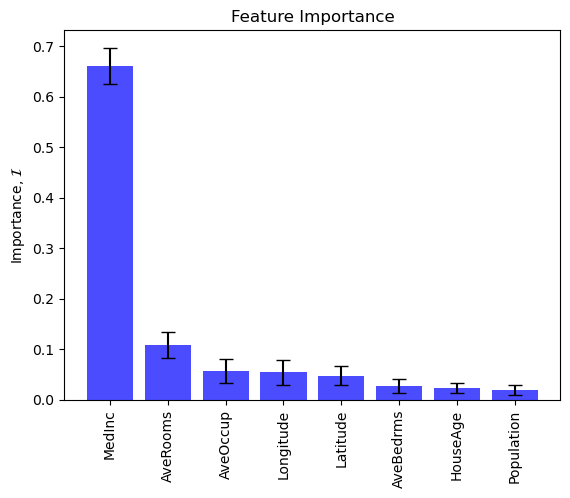

In [74]:
# Computing feature importances,
importances = sk_regressor.feature_importances_
importances_vars = np.var(np.array([tree.feature_importances_ for tree in sk_regressor.estimators_]), axis=0)

# Sorting features by on their importances,
idxs_sorted = np.argsort(importances)[::-1]
importances_sorted = importances[idxs_sorted]
importances_std_sorted = np.sqrt(importances_vars[idxs_sorted]) # <-- Standard deviation

# Plotting,
fig, ax = plt.subplots()
ax.bar(feature_names_sorted, importances_sorted, yerr=importances_std_sorted, 
       color="blue", alpha=0.7, capsize=5)
ax.set_ylabel(r"Importance, $\mathcal{I}$")
ax.set_title("Feature Importance")
plt.xticks(rotation=90)
plt.show()

In [66]:
tree_importances = np.array([tree.feature_importances_ for tree in sk_regressor.estimators_])
importances

array([0.64297427, 0.02261777, 0.06739518, 0.02429977, 0.02669927,
       0.1147512 , 0.05489967, 0.04636288])

In [67]:
std_importances = np.std(tree_importances, axis=0)

In [68]:
std_importances

array([0.05625232, 0.01216308, 0.03972397, 0.01199189, 0.01071106,
       0.02996405, 0.02252229, 0.01765585])